In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

## Table of Contents
- [Generating metric emotion correlation tables](#comparison)
- [Analysis of emo-metric-table](#weightings)

<a class="anchor" id="comparison"></a>
### Generating metric emotion correlation tables

In [2]:
networks = list(index2region.keys())

select   = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

In [7]:
movienames = [moviename.split('_')[0] for moviename in os.listdir('./resources/dynamic_grad/group_level414') 
              if '80_2' in moviename ]

In [8]:
for moviename in tqdm(movienames):
    if moviename == "Rest": continue
    # 1. Loading Gradient
    G_movie, varM = load('./resources/dynamic_grad/group_level414/{}_80_2_grad.pkl'.format(moviename))
    
    # 2. Loading Matching Emotion Track
    if moviename == 'BetweenViewing':
        moviename += 's'
    full_df  = pd.read_csv('./data/emoFiles/emotion_compile.csv')
    emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
    other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

    # Grid for each network of correlation with emotions
    grad_idx = 0
    smfactor = 1
    tolshift = 0

    n = len(networks)
    m = len(select)

    pairs = [("Vis", "Default"), ("SomMot", "Default"), 
            ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
            ("DorsAttn", "Default"), ("Limbic", "Default"), ("Cont", "Default"), ("Sub", "Default")]
    nb_metric = 6
    scores    = np.zeros((nb_metric, n,m))
    nscores   = np.zeros((nb_metric, n,m))

    # METRIC 1
    for idx, pair in enumerate(tqdm(pairs)):
        p1,p2 = pair
        y     = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                        for t in range(len(G_movie))])
        z1 = zscore(y)
        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series   = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened   = overlap_add(emo_series, smfactor)
            z2 = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr     = moviemix_stat_test(z1, z2, concat_other)
            nscores[0, idx,jdx] = nscore
            scores[0, idx,jdx]  = corr

    # METRIC 3
    for idx, R in enumerate(tqdm(networks)):
        y  = np.asarray([network_volume(G_movie[t], R) 
                        for t in range(len(G_movie))])
        z1 = zscore(y)

        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series   = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened   = overlap_add(emo_series, smfactor)
            z2 = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr     = moviemix_stat_test(z1, z2, concat_other)
            nscores[2, idx,jdx] = nscore
            scores[2, idx,jdx]  = corr

    # METRIC 4
    for idx, R in enumerate(tqdm(networks[:3])):
        y  = varM[:,idx]
        z1 = zscore(y)

        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series   = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened   = overlap_add(emo_series, smfactor)
            z2 = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr     = moviemix_stat_test(z1, z2, concat_other)
            nscores[3, idx,jdx] = nscore
            scores[3, idx,jdx]  = corr

    save('./resources/emo_metric_table/{}_80_2.pkl'.format(moviename),(nscores,scores))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### Analysis of emo-metric-table

In [29]:
permovies   = {}
countmovies = {}
for file in os.listdir('./resources/emo_metric_table/'):
    if '80' in file: continue
    nscores, scores = load('./resources/emo_metric_table/{}'.format(file))
    chop = (nscores < 0.05) * scores
    permovies[file.split('.')[0]]   = chop
    countmovies[file.split('.')[0]] = np.array(nscores < 0.01 * (np.abs(scores) > 0.5) , dtype=float)

<AxesSubplot:title={'center':'Number of significant correlations at 0.95'}>

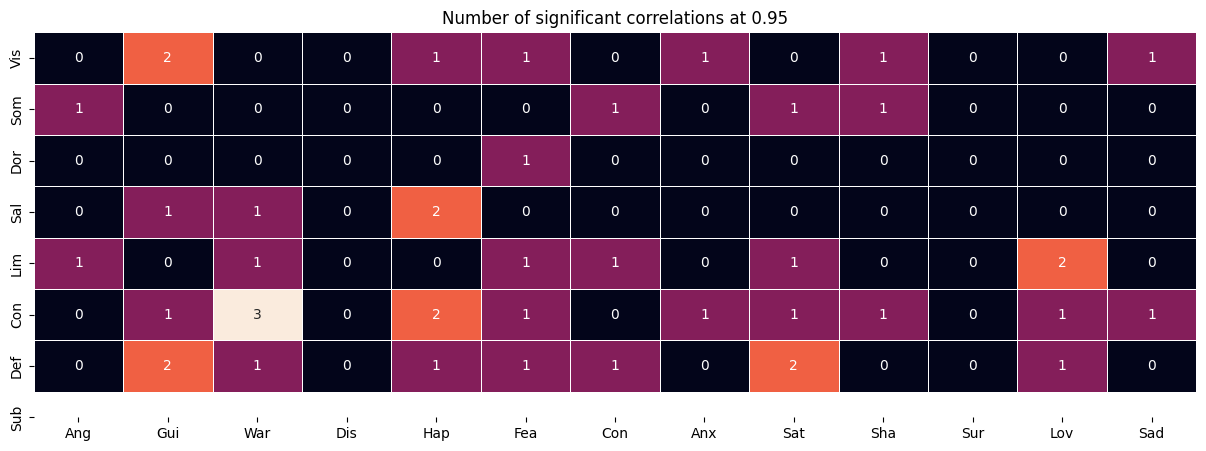

In [30]:
plt.figure(figsize=(15,5))
plt.title("Number of significant correlations at 0.95")
x_axis_labels = [f[:3] for f in select] # labels for x-axis
y_axis_labels = [f[:3] for f in networks] # labels for x-axis
sns.heatmap(np.asarray(list(countmovies.values())).sum(axis=0)[2], linewidth=0.5,  
            annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels,  cbar=False)

<AxesSubplot:title={'center':'Number of significant correlations at 0.99'}>

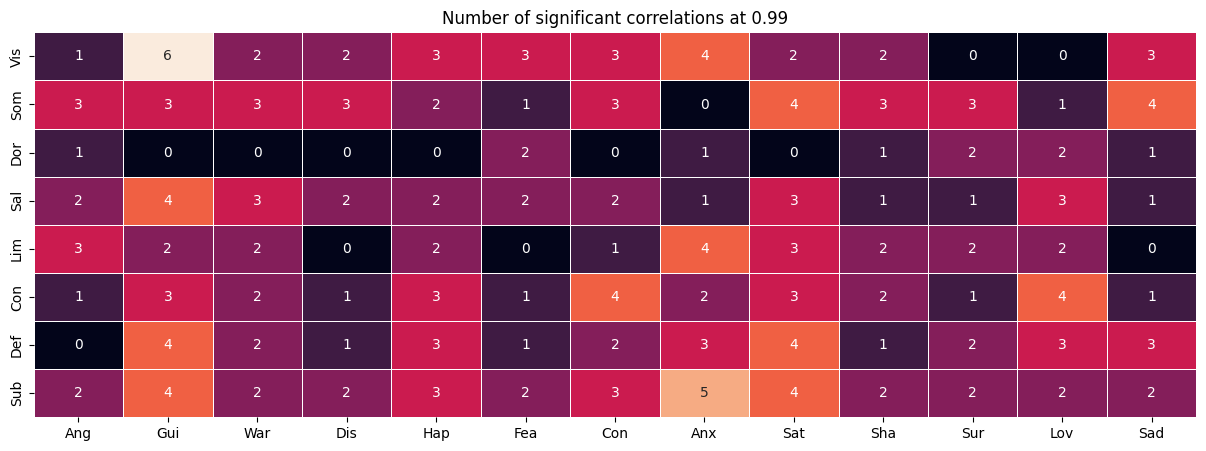

In [12]:
plt.figure(figsize=(15,5))
plt.title("Number of significant correlations at 0.99")
x_axis_labels = [f[:3] for f in select] # labels for x-axis
y_axis_labels = [f[:3] for f in networks] # labels for x-axis
sns.heatmap(np.asarray(list(countmovies.values())).sum(axis=0)[2], linewidth=0.5,  annot=True, 
            xticklabels=x_axis_labels, yticklabels=y_axis_labels,  cbar=False)